# comprendre la donnée

In [4]:
import pandas as pd

In [5]:
df_meta = pd.read_csv('./birdclef-2024/train_metadata.csv')
df_birbs = pd.read_csv('./birdclef-2024/eBird_Taxonomy_v2021.csv')

In [6]:
df_meta.groupby('primary_label')

In [7]:
# show unique primary labels
# print(df_meta['primary_label'].unique())

# for each primary label, show the number of samples
print(df_meta['primary_label'].value_counts())



primary_label
zitcis1    500
lirplo     500
litgre1    500
comgre     500
comkin1    500
          ... 
blaeag1      6
wynlau1      6
niwpig1      5
asiope1      5
integr       5
Name: count, Length: 182, dtype: int64


In [8]:
# secondary labels are in the form of a list of strings, so we need to split them into separate columns to count them
df_meta['secondary_labels'] = df_meta['secondary_labels'].str.split('|')
df_meta = df_meta.explode('secondary_labels')

In [9]:
df_meta.columns

Index(['primary_label', 'secondary_labels', 'type', 'latitude', 'longitude',
       'scientific_name', 'common_name', 'author', 'license', 'rating', 'url',
       'filename'],
      dtype='object')

# CNN test 1


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam

In [11]:
# Fonctions pour load les audio puis en créer des images

def load_audio(file_path, sr=22050):
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

def get_spectrogram(audio, sr=22050, n_mels=128, fmax=8000):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmax=fmax)
    return spectrogram

def generate_spectrogram(row, audio_dir, audio_len=22050*5, n_mels=128, fmax=8000, fixed_shape=(128, 128)):
    file_path = os.path.join(audio_dir, row['filename'])
    audio, sr = load_audio(file_path)
    audio = audio[:audio_len]
    spec = get_spectrogram(audio, sr=sr, n_mels=n_mels, fmax=fmax)
    spec_db = librosa.power_to_db(spec, ref=np.max)

    # Ensure the spectrogram has the fixed shape
    if spec_db.shape[1] < fixed_shape[1]:
        padding = fixed_shape[1] - spec_db.shape[1]
        spec_db = np.pad(spec_db, ((0, 0), (0, padding)), mode='constant')
    else:
        spec_db = spec_db[:, :fixed_shape[1]]

    return spec_db

def preprocess_metadata(df, meta_columns):
    for col in meta_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=meta_columns)  # Drop rows with NaN values in meta columns
    return df



In [12]:

def build_cnn_model(input_shape=(128, 128, 1), num_meta_features=2, num_classes=10):
    # Image input branch
    img_input = Input(shape=input_shape, name='img_input')
    x = Conv2D(32, (3, 3), activation='relu')(img_input)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    
    # Metadata input branch
    meta_input = Input(shape=(num_meta_features,), name='meta_input')
    y = Dense(128, activation='relu')(meta_input)
    y = Dropout(0.5)(y)
    
    # Concatenate the outputs of the image and metadata branches
    combined = concatenate([x, y])
    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(num_classes, activation='softmax')(z)
    
    model = Model(inputs=[img_input, meta_input], outputs=z)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

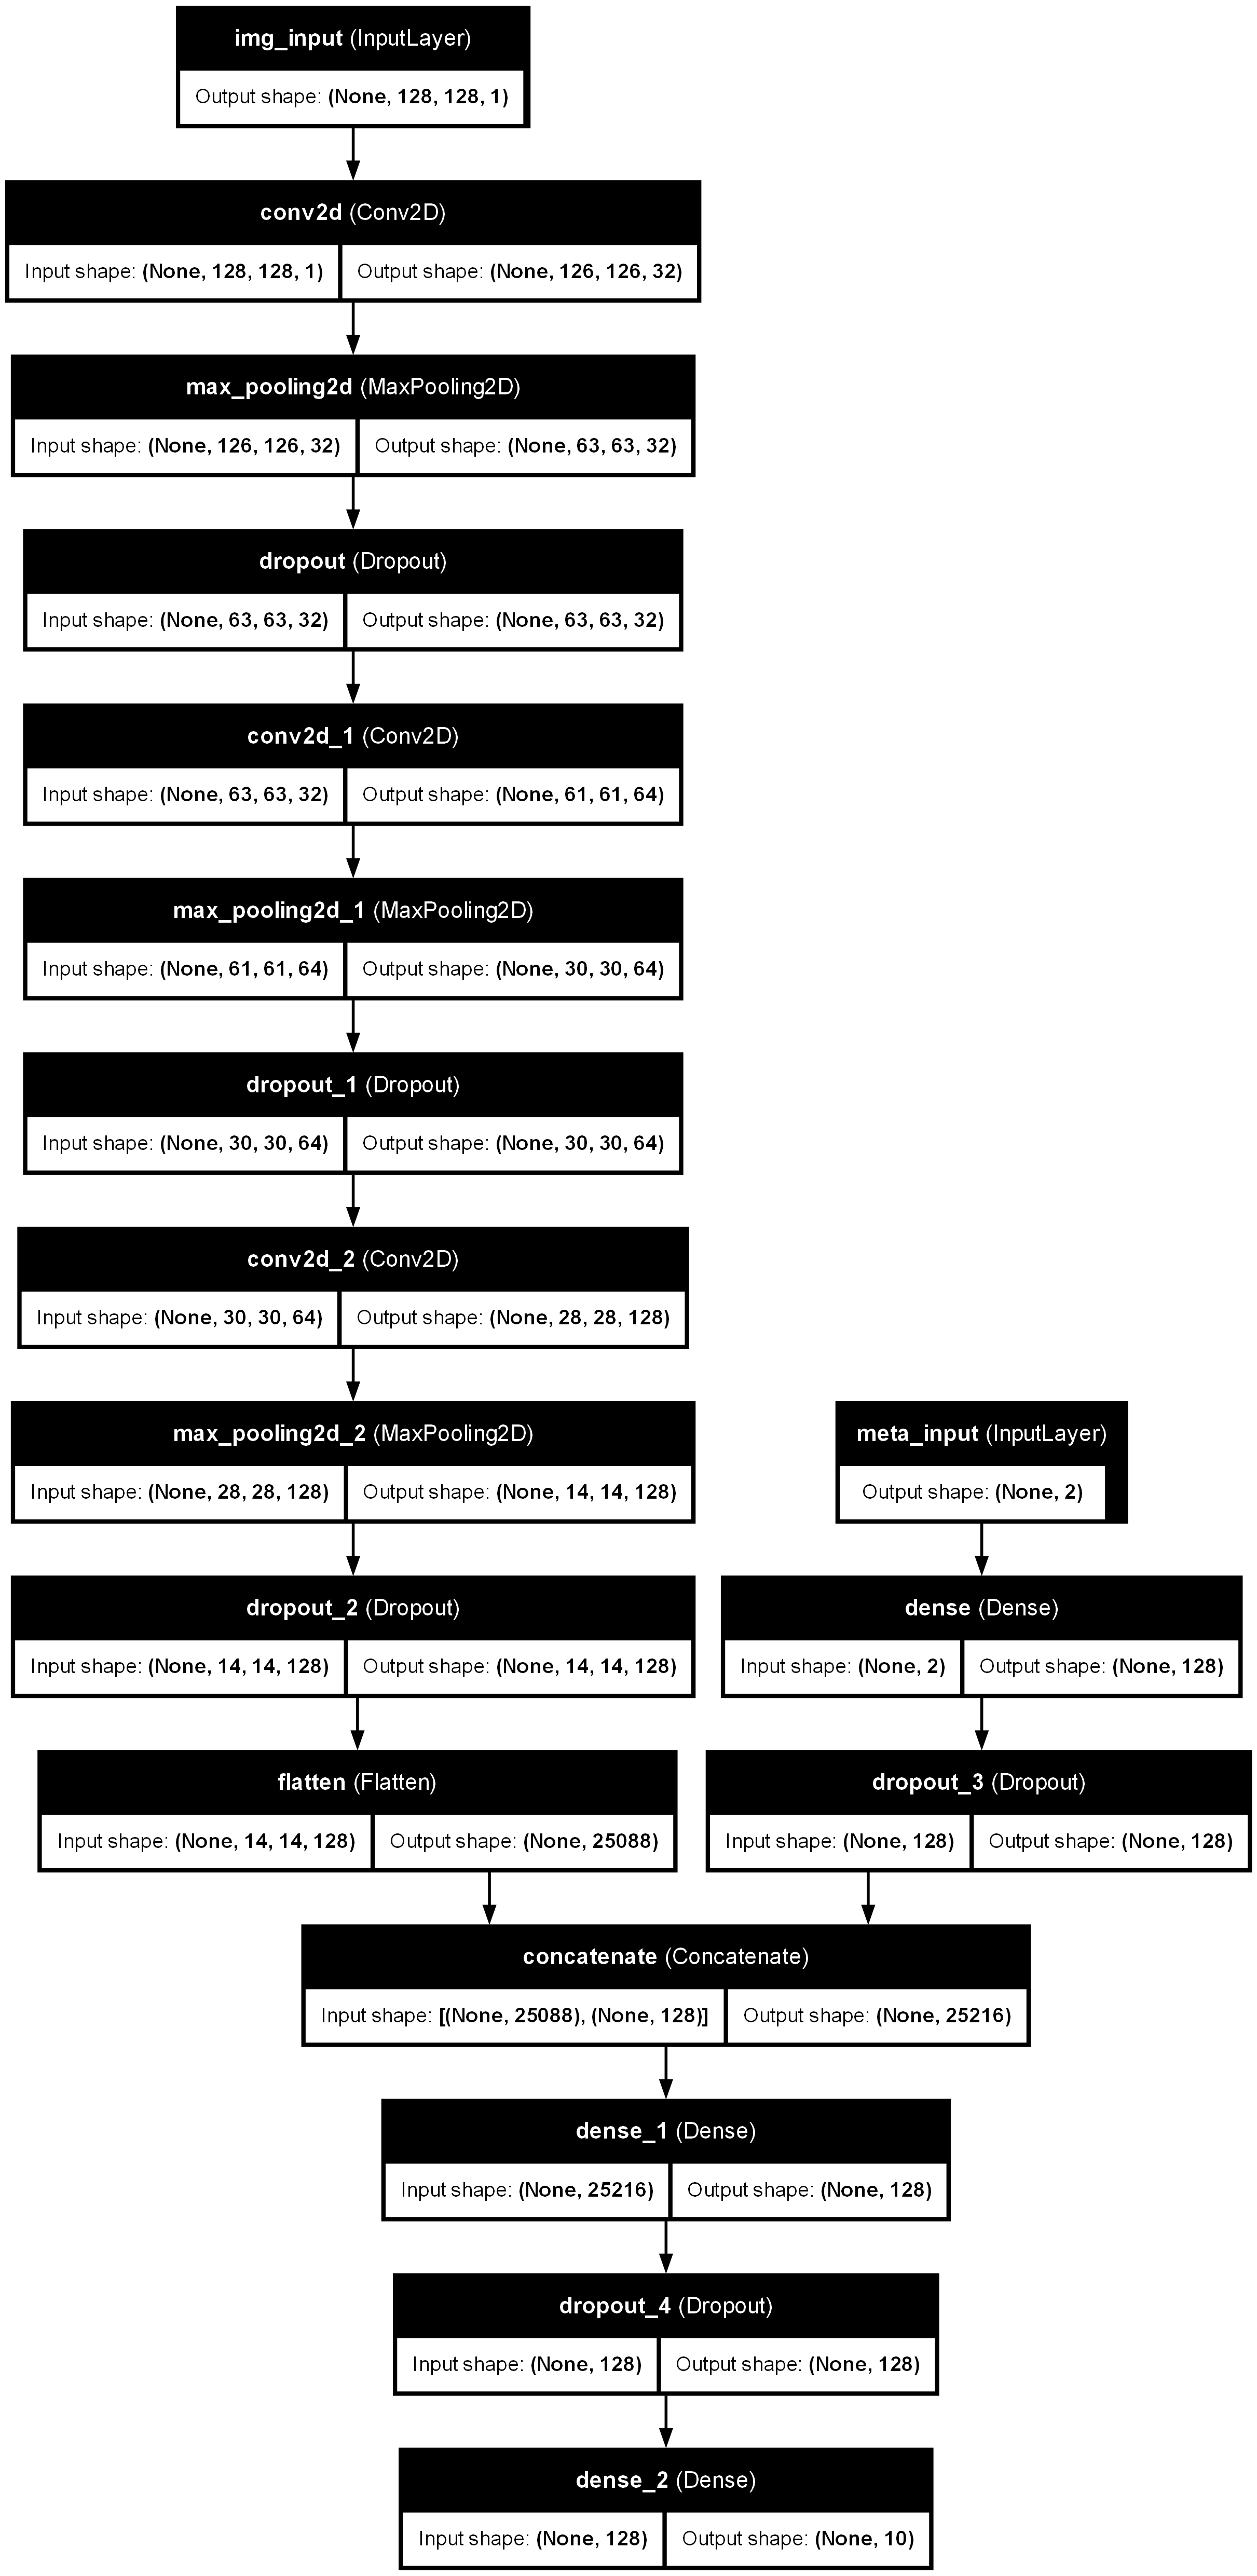

In [13]:
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

# Build the model
model = build_cnn_model(input_shape=(128, 128, 1), num_meta_features=2, num_classes=10)

# Visualize the model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [14]:

def data_generator(df, audio_dir, batch_size, input_shape, meta_columns, num_classes):
    df = preprocess_metadata(df, meta_columns)  # Ensure metadata is numeric
    num_samples = len(df)
    while True:
        df = df.sample(frac=1).reset_index(drop=True)
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset+batch_size]
            batch_spectrograms = []
            batch_meta_data = []
            batch_labels = []
            for _, row in batch_df.iterrows():
                spec = generate_spectrogram(row, audio_dir, fixed_shape=(input_shape[0], input_shape[1]))
                batch_spectrograms.append(spec)
                batch_meta_data.append(row[meta_columns].values.astype(float))  # Ensure meta data is float
                batch_labels.append(row['primary_label'])
                
            X_img = np.array(batch_spectrograms)[..., np.newaxis]
            X_meta = np.array(batch_meta_data)
            # Convert labels to categorical using Pandas category codes
            y_labels = pd.Categorical(batch_labels).codes
            y = to_categorical(y_labels, num_classes=num_classes)
            
            yield {'img_input': X_img, 'meta_input': X_meta}, y



def train_model(metadata_path, audio_dir, batch_size=32, epochs=10, input_shape=(128, 128, 1), meta_columns=['latitude', 'longitude']):
    # Load metadata
    df = pd.read_csv(metadata_path)
    df = preprocess_metadata(df, meta_columns)  # Ensure metadata is numeric
    num_classes = df['primary_label'].nunique()

    # Train-validation split
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # Build the model
    model = build_cnn_model(input_shape=input_shape, num_meta_features=len(meta_columns), num_classes=num_classes)

    # Create data generators
    train_generator = data_generator(train_df, audio_dir, batch_size, input_shape, meta_columns, num_classes)
    val_generator = data_generator(val_df, audio_dir, batch_size, input_shape, meta_columns, num_classes)

    steps_per_epoch = len(train_df) // batch_size
    validation_steps = len(val_df) // batch_size

    # Train the model
    model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=epochs
    )

    return model



In [15]:

# # Example usage:
# metadata_path = './birdclef-2024/train_metadata.csv'
# audio_dir = './birdclef-2024/train_audio/'
# model = train_model(metadata_path, audio_dir, batch_size=32, epochs=10, input_shape=(128, 128, 1), meta_columns=['latitude', 'longitude'])


In [16]:

# model.save('./models/25_05_2024_18-46/bird_species_classifier_model.keras')

In [28]:
import tensorflow as tf
# check gpu
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [27]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if tf.config.experimental.list_physical_devices('GPU'):
    print("TensorFlow can access the GPU")
else:
    print("TensorFlow cannot access the GPU")

TensorFlow version: 2.16.1
Num GPUs Available:  0
TensorFlow cannot access the GPU


In [19]:
# print the version of python
import sys
print(sys.version)


3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [20]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs found:", gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs found.")

# Create a simple model to test cuDNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

print("cuDNN and TensorFlow are configured correctly if the model summary is printed without errors.")


TensorFlow version: 2.16.1
No GPUs found.


C:\Users\Rami\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

cuDNN and TensorFlow are configured correctly if the model summary is printed without errors.


In [21]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if tf.config.experimental.list_physical_devices('GPU'):
    print("TensorFlow can access the GPU")
else:
    print("TensorFlow cannot access the GPU")

# Simple operation to test GPU usage
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.matmul(a, a)
print("Result of matrix multiplication:\n", b)


TensorFlow version: 2.16.1
Num GPUs Available:  0
TensorFlow cannot access the GPU
Result of matrix multiplication:
 tf.Tensor(
[[ 7. 10.]
 [15. 22.]], shape=(2, 2), dtype=float32)


# Test CNN avec juste l'audio (pcq askip on a pas le droit au metadata)

In [22]:

def build_cnn_model_2(input_shape=(128, 128, 1), num_classes=10):
    # Image input branch
    img_input = Input(shape=input_shape, name='img_input')
    x = Conv2D(32, (3, 3), activation='relu')(img_input)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    z = Dense(128, activation='relu')(x)
    z = Dropout(0.5)(z)
    z = Dense(num_classes, activation='softmax')(z)
    
    model = Model(inputs=[img_input], outputs=z)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

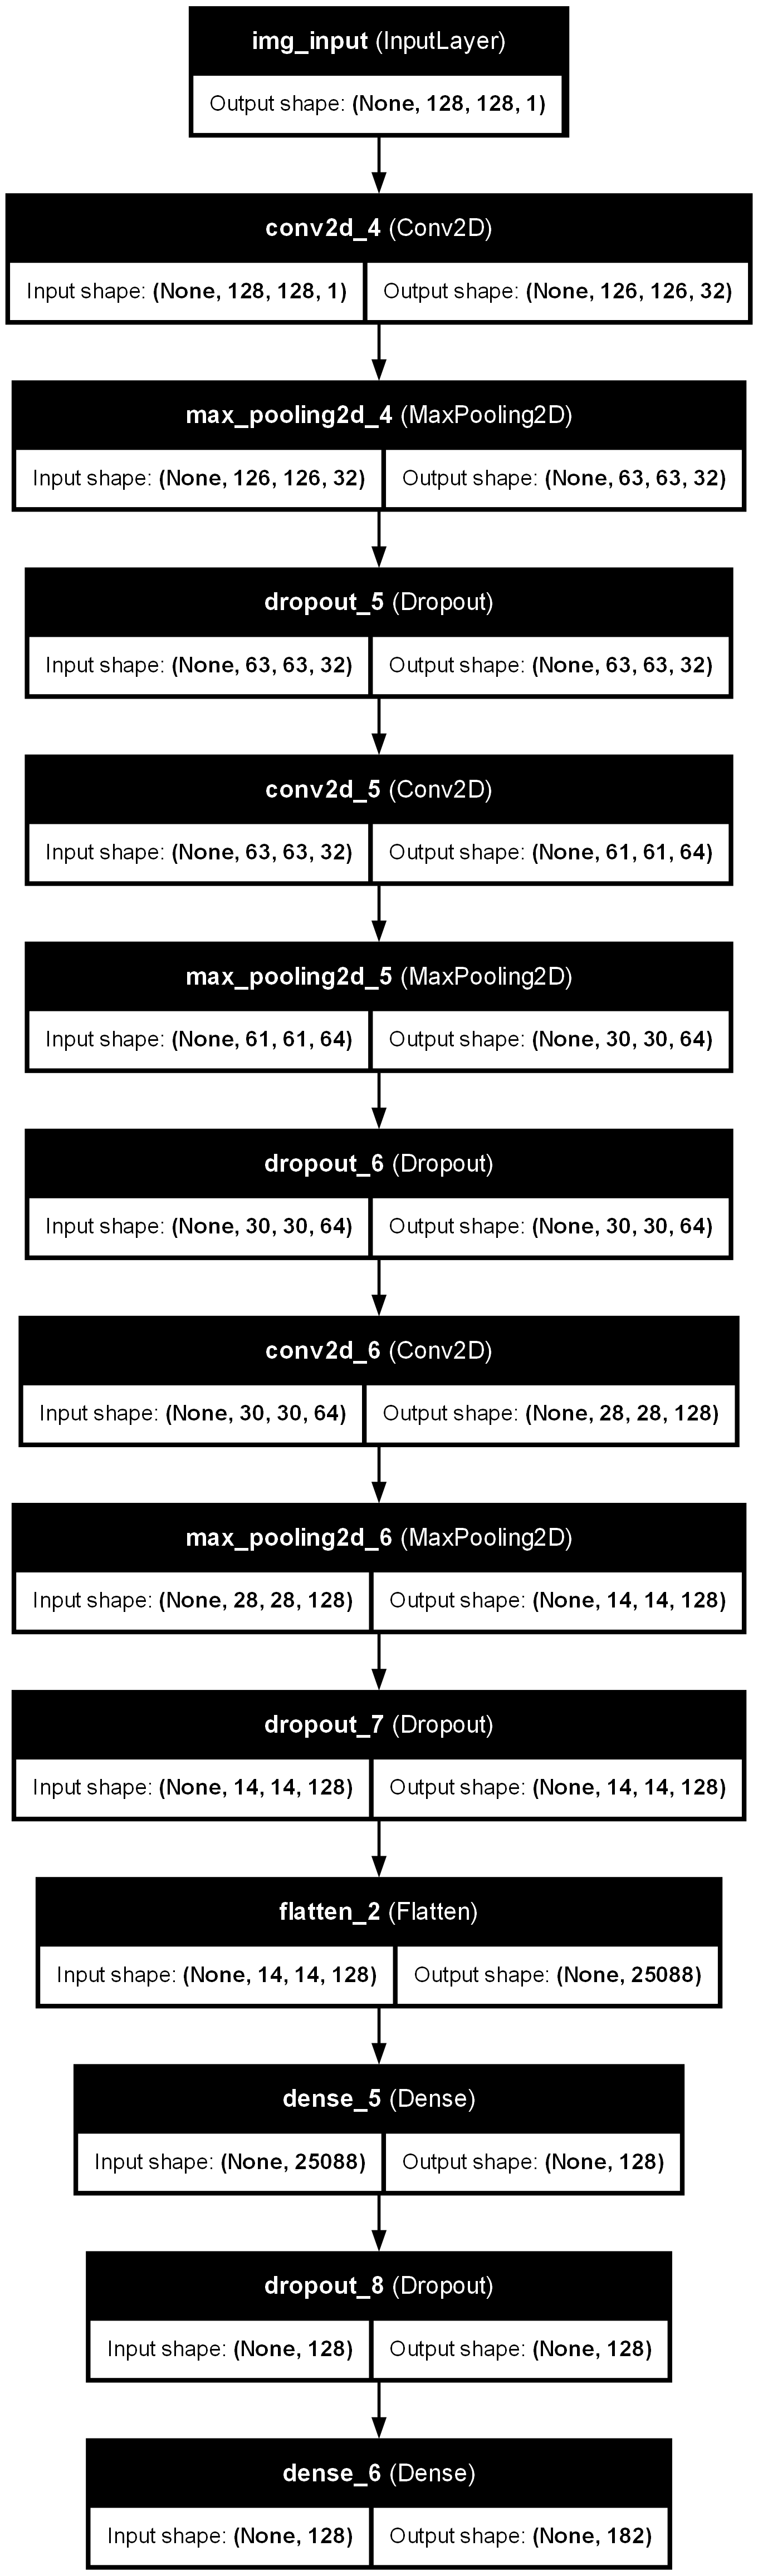

In [23]:
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

# Build the model
model = build_cnn_model_2(input_shape=(128, 128, 1), num_classes=len(df_meta["primary_label"].unique()))

# Visualize the model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [30]:

def data_generator(df, audio_dir, batch_size, input_shape, meta_columns, num_classes):
    df = preprocess_metadata(df, meta_columns)  # Ensure metadata is numeric
    num_samples = len(df)
    while True:
        df = df.sample(frac=1).reset_index(drop=True)
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset+batch_size]
            batch_spectrograms = []
            batch_meta_data = []
            batch_labels = []
            for _, row in batch_df.iterrows():
                spec = generate_spectrogram(row, audio_dir, fixed_shape=(input_shape[0], input_shape[1]))
                batch_spectrograms.append(spec)
                batch_meta_data.append(row[meta_columns].values.astype(float))  # Ensure meta data is float
                batch_labels.append(row['primary_label'])
                
            X_img = np.array(batch_spectrograms)[..., np.newaxis]
            X_meta = np.array(batch_meta_data)
            # Convert labels to categorical using Pandas category codes
            y_labels = pd.Categorical(batch_labels).codes
            y = to_categorical(y_labels, num_classes=num_classes)
            
            yield {'img_input': X_img, 'meta_input': X_meta}, y



def train_model(metadata_path, audio_dir, batch_size=32, epochs=10, input_shape=(128, 128, 1), meta_columns=[]):
    # Load metadata
    df = pd.read_csv(metadata_path)
    df = preprocess_metadata(df, meta_columns)  # Ensure metadata is numeric
    num_classes = df['primary_label'].nunique()

    # Train-validation split
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # Build the model
    model = build_cnn_model(input_shape=input_shape, num_meta_features=len(meta_columns), num_classes=num_classes)

    # Create data generators
    train_generator = data_generator(train_df, audio_dir, batch_size, input_shape, meta_columns, num_classes)
    val_generator = data_generator(val_df, audio_dir, batch_size, input_shape, meta_columns, num_classes)

    steps_per_epoch = len(train_df) // batch_size
    validation_steps = len(val_df) // batch_size

    # Train the model
    model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=epochs
    )

    return model



In [ ]:

metadata_path = './birdclef-2024/train_metadata.csv'
audio_dir = './birdclef-2024/train_audio/'
model = train_model(metadata_path, audio_dir, batch_size=32, epochs=10, input_shape=(128, 128, 1), meta_columns=['latitude', 'longitude'])